# Premier League Transfer Fees and Player Performance Analysis Project (2023/24)

## 1. Data Collection: FBRef (Performance Statistics)

In [483]:
import requests
import pandas as pd
from bs4 import BeautifulSoup, Comment
import os

URL = 'https://fbref.com/en/comps/9/2023-2024/stats/2023-2024-Premier-League-Stats'
TABLE_ID = 'stats_standard'
HEADERS = {'User-Agent': 'Mozilla/5.0'}

OUTPUT = '/Users/sungwon/BEE2041/PremierLeague_Transfer_Performance_Project/data/raw/fbref_player_stats_2023.csv'
print(f"📁 CSV will be saved to: {OUTPUT}")

resp = requests.get(URL, headers=HEADERS)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, 'html.parser')

table = soup.find('table', id=TABLE_ID)
if not table:
    comment = next(
        (c for c in soup.find_all(string=lambda t: isinstance(t, Comment)) if TABLE_ID in c),
        ''
    )
    table = BeautifulSoup(comment, 'html.parser').find('table', id=TABLE_ID)
if table is None:
    raise RuntimeError(f"Table with id='{TABLE_ID}' not found")

html = str(table)

for header in (1, 0):
    try:
        df = pd.read_html(html, header=header)[0]
        break
    except ValueError:
        df = None
if df is None:
    raise RuntimeError("Failed to parse table into DataFrame")

def clean(col):
    s = '_'.join(col) if isinstance(col, tuple) else str(col)
    return s.strip().replace(' ', '_').replace('-', '_').replace('#', 'Num')

df.columns = [clean(c) for c in df.columns]

first_col = df.columns[0]
df = df[df[first_col] != first_col].dropna(how='all')

os.makedirs(os.path.dirname(OUTPUT), exist_ok=True)
df.to_csv(OUTPUT, index=False, encoding='utf-8')
print(f"Saved {df.shape[0]} rows to {OUTPUT}")

📁 CSV will be saved to: /Users/sungwon/BEE2041/PremierLeague_Transfer_Performance_Project/data/raw/fbref_player_stats_2023.csv
Saved 580 rows to /Users/sungwon/BEE2041/PremierLeague_Transfer_Performance_Project/data/raw/fbref_player_stats_2023.csv


## 2. Data Collection: Transfermarkt (Transfer Fees)

In [485]:
pip install selenium pandas

Note: you may need to restart the kernel to use updated packages.


In [486]:
import os
import re
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup

URL = 'https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1/plus/?saison_id=2023&s_w=s&leihe=0&intern=0'
DRIVER_PATH = '/Users/sungwon/Downloads/chromedriver-mac-arm64/chromedriver'
OUTPUT = 'data/raw/transfermarkt_transfer_fees_2023_selenium.csv'

def clean_fee(f):
    """Convert fee text like '€2.5m' or '€300k' into float euros."""
    if not f or f.strip() in ('-', '?') or 'free' in f.lower():
        return 0.0
    m = re.search(r'€([\d\.,]+)([mk]?)', f.lower())
    if not m:
        return 0.0
    val = float(m.group(1).replace('.', '').replace(',', '.'))
    if m.group(2) == 'm': val *= 1e6
    if m.group(2) == 'k': val *= 1e3
    return val

driver = webdriver.Chrome(service=Service(DRIVER_PATH))
driver.get(URL)
soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

records = []
for box in soup.select('div.box'):

    club_tag = box.select_one('h2.content-box-headline a:nth-of-type(2)') \
            or box.select_one('h2.content-box-headline a')
    if not club_tag or not club_tag.text.strip():
        continue
    club = club_tag.text.strip()

    tbl = box.select_one('div.responsive-table table')
    if not tbl:
        continue

    for tr in tbl.select('tbody tr'):
        cols = tr.select('td')
        if len(cols) < 8:
            continue

        player = cols[0].get_text(strip=True)
        origin = cols[-3].get_text(strip=True) or 'Unknown'
        fee_txt = cols[-1].get_text(strip=True) or '-'

        if origin.lower() == 'without club':
            origin = 'Without Club'

        records.append({
            'Player': player,
            'Destination Club': club,
            'Origin Club': origin,
            'Fee Text': fee_txt,
            'Transfer Fee (EUR)': clean_fee(fee_txt)
        })
     
df = pd.DataFrame(records)
os.makedirs(os.path.dirname(OUTPUT), exist_ok=True)
df.to_csv(OUTPUT, index=False, encoding='utf-8')
print(f"Saved {len(df)} transfers to {OUTPUT}")

Saved 126 transfers to data/raw/transfermarkt_transfer_fees_2023_selenium.csv


## 3. Data Cleaning and Merging

In [488]:
import pandas as pd
import re
import os
import difflib

fbref_fp     = '/Users/sungwon/BEE2041/PremierLeague_Transfer_Performance_Project/data/raw/fbref_player_stats_2023.csv'
tm_fp        = '/Users/sungwon/BEE2041/data/raw/transfermarkt_transfer_fees_2023_selenium.csv'
temp_output  = '/Users/sungwon/BEE2041/PremierLeague_Transfer_Performance_Project/data/processed/merged_full_data.csv'
final_output = '/Users/sungwon/BEE2041/PremierLeague_Transfer_Performance_Project/data/processed/merged_matched_data.csv'

fbref = pd.read_csv(fbref_fp)
tm    = pd.read_csv(tm_fp)

def normalize_name(name):
    s = re.sub(r'[^A-Za-z\-\s]', '', str(name)).strip()
    parts = s.split()
    return f"{parts[0]} {parts[-1]}" if len(parts) >= 3 else " ".join(parts)

fbref['Norm'] = fbref['Player'].apply(normalize_name)
tm   ['Norm'] = tm   ['Player'].apply(normalize_name)

fb_names = fbref['Norm'].unique().tolist()
mapping = {}
for nm in tm['Norm'].unique():
    if nm not in fb_names:
        best = difflib.get_close_matches(nm, fb_names, n=1, cutoff=0.8)
        if best:
            mapping[nm] = best[0]
tm['Norm'] = tm['Norm'].replace(mapping)

fb_cols = [
    'Norm', 'Pos', 'Age', 'MP', 'Min',
    'Gls', 'Ast',
    'xG', 'xAG',
    'PrgC', 'PrgP', 'PrgR'
]
fb_perf = fbref[fb_cols].drop_duplicates(subset=['Norm'])

merged = pd.merge(tm, fb_perf, on='Norm', how='left', indicator=True)
matched = merged[merged['_merge']=='both'].copy()

matched = matched[matched['Pos']!='GK']
matched['Pos'] = matched['Pos'].str.split(',', n=1).str[0]

matched['Age'] = matched['Age'].fillna(matched['Age'].median())
for c in ['MP','Min','Gls','Ast','xG','xAG','PrgC','PrgP','PrgR']:
    matched[c] = matched[c].fillna(0)

matched['G_A']         = matched['Gls'] + matched['Ast']
matched['G_A_per90']   = matched['G_A']   / (matched['Min']/90)
matched['xG_per90']    = matched['xG']    / (matched['Min']/90)
matched['xAG_per90']   = matched['xAG']   / (matched['Min']/90)
matched['PrgC_per90']  = matched['PrgC']  / (matched['Min']/90)
matched['PrgP_per90']  = matched['PrgP']  / (matched['Min']/90)
matched['PrgR_per90']  = matched['PrgR']  / (matched['Min']/90)

matched = matched.drop(columns=['Norm','_merge'])
cols = [
    'Player', 'Destination Club', 'Pos', 'Age', 'Transfer Fee (EUR)', 'MP', 'Min',
    'Gls', 'Ast', 'G_A', 'G_A_per90',
    'xG_per90', 'xAG_per90',
    'PrgC_per90', 'PrgP_per90', 'PrgR_per90'
]
matched = matched[cols]

os.makedirs(os.path.dirname(final_output), exist_ok=True)
matched.to_csv(final_output, index=False, encoding='utf-8')
print(f"Saved matched & cleaned data ({len(matched)} rows) to:\n  {final_output}")

Saved matched & cleaned data (100 rows) to:
  /Users/sungwon/BEE2041/PremierLeague_Transfer_Performance_Project/data/processed/merged_matched_data.csv


## 4. Exploratory Data Analysis

In [490]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_style('whitegrid')
sns.set_palette('tab10')

fp = '/Users/sungwon/BEE2041/PremierLeague_Transfer_Performance_Project/data/processed/merged_matched_data.csv'
df = pd.read_csv(fp)

df['logFee'] = np.log1p(df['Transfer Fee (EUR)'])

def perf_metric(r):
    if r.Pos == 'FW':
        return r.G_A_per90
    if r.Pos == 'MF':
        return r.xG_per90 + r.xAG_per90
    if r.Pos == 'DF':
        return r.PrgC_per90
    return np.nan

df['Perf'] = df.apply(perf_metric, axis=1)

position_means = df.groupby('Pos')['Perf'].mean()
df['Perf_Ratio'] = df.apply(lambda r: r['Perf'] / position_means[r['Pos']], axis=1)

### 4.1 Transfer Fee Distribution: Original vs Log-Transformed

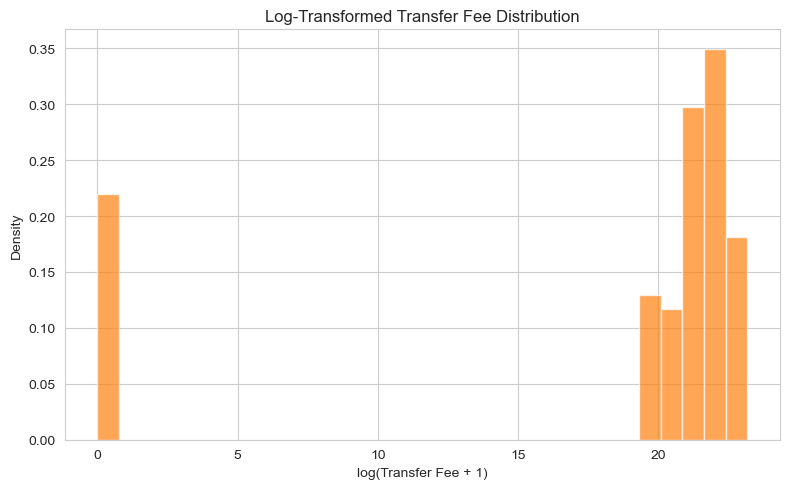

In [492]:
plt.figure(figsize=(8,5))
plt.hist(
    df['logFee'],
    bins=30,
    alpha=0.7,
    color='C1',
    edgecolor='white',
    density=True
)
plt.title('Log-Transformed Transfer Fee Distribution')
plt.xlabel('log(Transfer Fee + 1)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### 4.2 log(Transfer Fee) vs Normalized Performance by Position

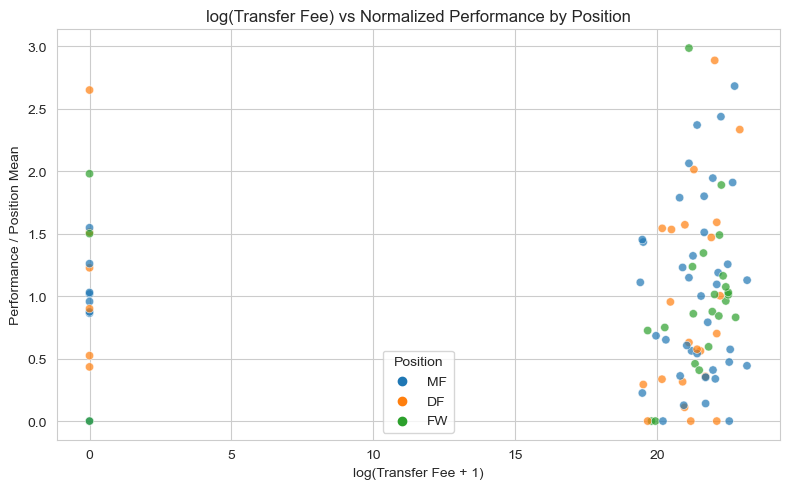

In [494]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='logFee', y='Perf_Ratio', hue='Pos', alpha=0.7)
plt.title('log(Transfer Fee) vs Normalized Performance by Position')
plt.xlabel('log(Transfer Fee + 1)')
plt.ylabel('Performance / Position Mean')
plt.legend(title='Position')
plt.tight_layout()
plt.show()

### 4.3 Normalized Performance by Transfer Fee Quartile and Position

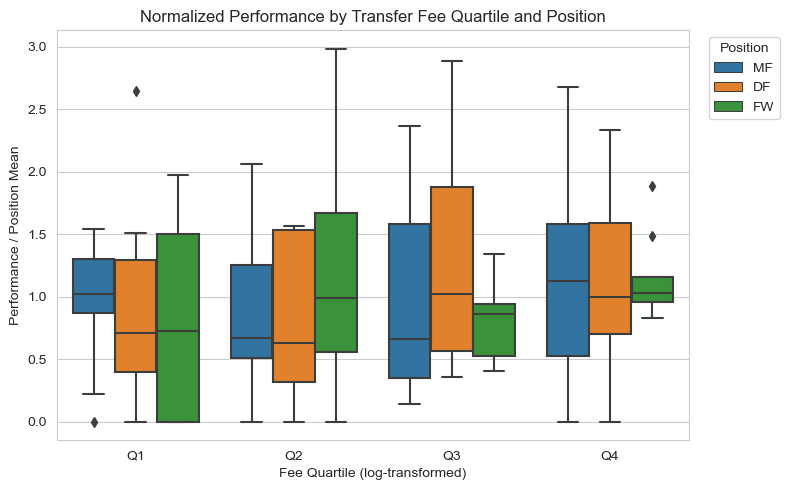

In [496]:
df['Fee_Quartile'] = pd.qcut(df['logFee'], 4, labels=['Q1','Q2','Q3','Q4'])
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Fee_Quartile', y='Perf_Ratio', hue='Pos')
plt.title('Normalized Performance by Transfer Fee Quartile and Position')
plt.xlabel('Fee Quartile (log-transformed)')
plt.ylabel('Performance / Position Mean')
plt.legend(title='Position', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Regression Analysis

### 5.1 log(Transfer Fee) vs Normalized Performance

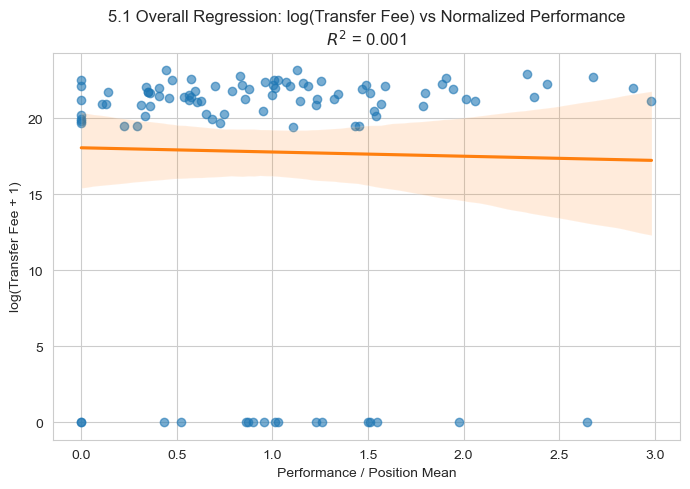

In [499]:
model = LinearRegression().fit(df[['Perf_Ratio']], df['logFee'])
r2 = model.score(df[['Perf_Ratio']], df['logFee'])
plt.figure(figsize=(7,5))
sns.regplot(data=df, x='Perf_Ratio', y='logFee', scatter_kws={'alpha':0.6}, line_kws={'color':'C1'})
plt.title(f'5.1 Overall Regression: log(Transfer Fee) vs Normalized Performance\n$R^2$ = {r2:.3f}')
plt.xlabel('Performance / Position Mean')
plt.ylabel('log(Transfer Fee + 1)')
plt.tight_layout()
plt.show()

### 5.2 log(Transfer Fee) vs Normalized Performance (MF / DF / FW)

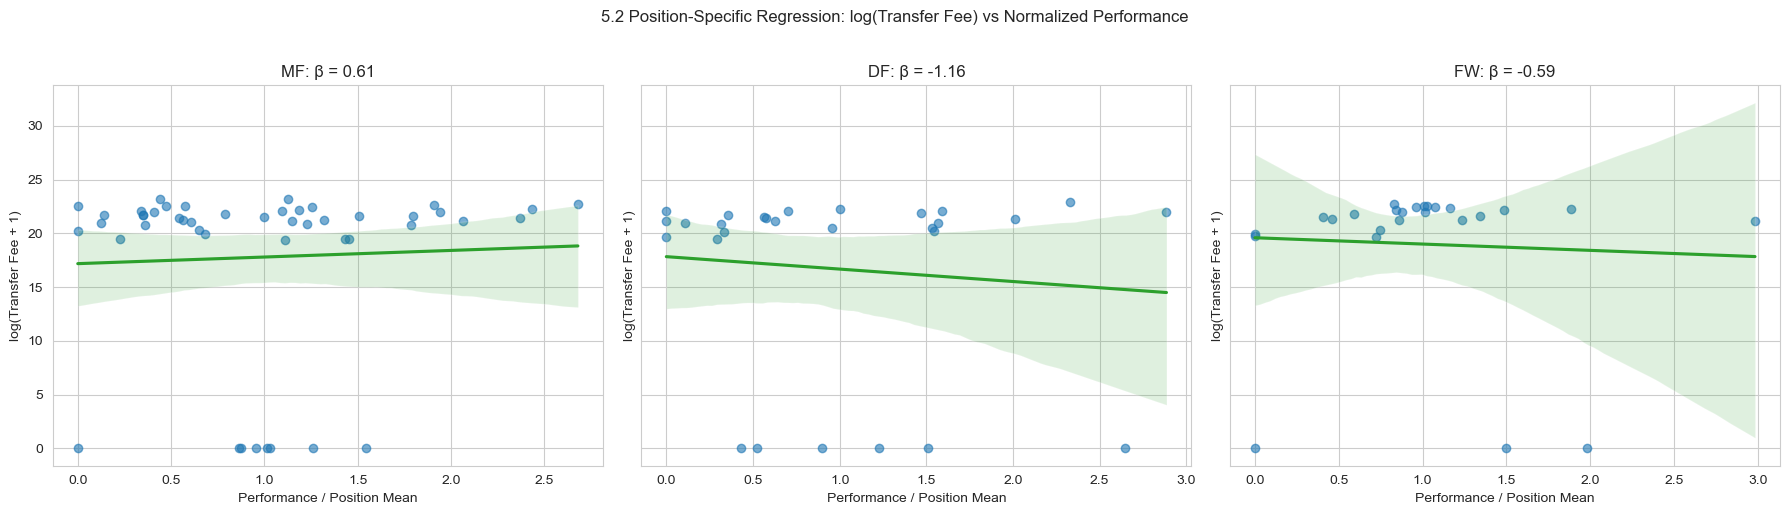

In [501]:
positions = ['MF','DF','FW']
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
for ax, pos in zip(axes, positions):
    sub = df[df['Pos'] == pos]
    beta = LinearRegression().fit(sub[['Perf_Ratio']], sub['logFee']).coef_[0]
    sns.regplot(data=sub, x='Perf_Ratio', y='logFee', ax=ax,
                scatter_kws={'alpha':0.6}, line_kws={'color':'C2'})
    ax.set_title(f'{pos}: β = {beta:.2f}')
    ax.set_xlabel('Performance / Position Mean')
    ax.set_ylabel('log(Transfer Fee + 1)')
plt.suptitle('5.2 Position-Specific Regression: log(Transfer Fee) vs Normalized Performance', y=1.02)
plt.tight_layout()
plt.show()